In [1]:
import _init_paths
import caffe
caffe.set_mode_gpu()
caffe.set_device(0)

import os,cv2
import matplotlib.pyplot as plt
import os.path as osp
import numpy as np

from data_layer.batch import get_minibatch
from utils.timer import Timer

from fast_rcnn.test import im_detect
from fast_rcnn.nms_wrapper import nms
from fast_rcnn.config import cfg
cfg.TEST.HAS_RPN = True

timer = Timer()

cfg.TEST.INPUT_SIZE = 224


TEST_CLASSES = {
    'hands': 'hands',
    'faces': 'faces',
    'human': 'human',
    'wlcoco':'wlcoco',
    'UniqueDET':'UniqueDET'
}
MODEL_CLASSES = {
    'vgg_small':'VGG_CNN_M_1024',
    'vgg_large':'VGG16'
}
TEST_CLASS = TEST_CLASSES['UniqueDET']


cfg.TEST.HAS_RPN = True  # Use RPN for proposals

MODELS_DIR = '/home/tomorning/Workspace/Recognition/models/'+ TEST_CLASS +'/test_uniqueDet.prototxt'
#NET = '/home/tomorning/Workspace/Recognition/out/' + 'UDET_iter_100000.caffemodel'
NET = '/home/tomorning/py-faster-rcnn/output/faster_rcnn_end2end/' + \
    'wlDet' + '/wlDet_valdata_vgg_cnn_m_1024_faster_rcnn_iter_20000.caffemodel'
DETS_DIR = '/home/tomorning/py-faster-rcnn/output/detections/faces_vgg16'
    
prototxt = MODELS_DIR
caffemodel = NET
if not os.path.isfile(caffemodel):
    raise IOError(('{:s} not found.\nDid you run ./data/script/'
                       'fetch_faster_rcnn_models.sh?').format(caffemodel))

#caffe.set_mode_gpu()
#caffe.set_device(0)

net = caffe.Net(prototxt, caffemodel, caffe.TEST)

print '\n\nLoaded network {:s}'.format(caffemodel)

CONF_THRESH = 0.8
NMS_THRESH = 0.15
min_box_size = 256



Loaded network /home/tomorning/py-faster-rcnn/output/faster_rcnn_end2end/wlDet/wlDet_valdata_vgg_cnn_m_1024_faster_rcnn_iter_20000.caffemodel


In [2]:
# dataset directory
DATA_DIR = osp.join('..', 'data', 'UniqueDET')

# load class labels and test roidb
from datafactory.load import load_images, load_sysnets, load_images_with_boxes
#test_roidb = load_images(DATA_DIR, fname='test.txt')
class_labels, class_indexes = load_sysnets(DATA_DIR)
CLASSES = [class_labels[i] for i in range(len(class_labels))]
test_roidb = load_images_with_boxes(DATA_DIR, class_indexes,fname='test.txt')
#print class_labels
num_classes = len(class_labels)
print 'Number of classes: {}'.format(num_classes)

Number of classes: 15


In [3]:
def vis_detections(im, class_names,dets,thresh = 0.8):
    """Draw detected bounding boxes."""
    if dets==None or len(dets) == 0:
        print 'Detect Nothing in THIS IMAGE!!!'
        return

    im = im[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(im, aspect='equal')
    #for bbox_score in dets:
    for ind in range(len(dets)):
        bbox_score = dets[ind]
        class_name = class_names[ind]
        bbox = bbox_score[:4]
        score = bbox_score[-1]

        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=3.5)
        )
        ax.text(bbox[0], bbox[1] - 2,
                 '{:s} {:.3f}'.format(class_name, score),
                 bbox=dict(facecolor='blue', alpha=0.5),
                 fontsize=14, color='white')

    ax.set_title(('{} detections with '
                   'p({} | box) >= {:.1f}').format(class_name, class_name,
                                                   thresh),
                  fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [4]:
def bbox_overlaps(gt_boxes, query_boxes):
    """
     Calculate the overlaps between ground-truth boxes and query boxes.
     boxes are in the form of (xmin, ymin, xmax, ymax).
     :return list of corresponding overlaps
    """
    
    def calculate_overlap(gt_box, query_boxes):
        overlaps = []
        
        box_area = (gt_box[2] * gt_box[3])
        for query_box in query_boxes:
            iw = (
                min(gt_box[0] + gt_box[2], query_box[0] + query_box[2]) -
                max(gt_box[0], query_box[0])
            )
            if iw > 0:
                ih = (
                    min(gt_box[1] + gt_box[3], query_box[1] + query_box[3]) -
                    max(gt_box[1], query_box[1])
                )
                if ih > 0:
                    ua = float(
                        box_area +
                        query_box[2] * query_box[3] -
                        iw * ih
                    )
                    overlaps.append(iw * ih / ua)
                else:
                    overlaps.append(0)
            else:
                overlaps.append(0)
        return np.array(overlaps, dtype=np.float32)[np.newaxis,:]
    
    gt_boxes[:, 2] -= gt_boxes[:, 0]
    gt_boxes[:, 3] -= gt_boxes[:, 1]
    query_boxes[:,2] -= query_boxes[:, 0]
    query_boxes[:,3] -= query_boxes[:, 1]
    overlaps = np.zeros((0, len(query_boxes)), dtype=np.float32)
    for gt_box in gt_boxes:
        _overlaps = calculate_overlap(gt_box, query_boxes)
        overlaps = np.vstack((overlaps, _overlaps))
    
    return overlaps

In [5]:
def load_ground_truth(names):
    ground_truths = []
    for name in names:
        xml = os.path.join('/home/tomorning/original_data/' +TEST_CLASS+ '/Annotations', name + '.xml')
        xml = open(xml, 'rb')
        tree = ET.parse(xml)
        root = tree.getroot()
        ground_truth_this = []
        for obj in root.iter('object'):
            xmlbox = obj.find('bndbox')
            b = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text), 
                 float(xmlbox.find('ymin').text), float(xmlbox.find('ymax').text))
            # convert to (x, y, w, h)
            xmin = int(b[0])
            ymin = int(b[2])
            xmax = int(b[1])
            ymax = int(b[3])
            this_gt_area = (ymax-ymin+1)* (xmax-xmin+1)
            #if this_gt_area <= min_box_size:
            if (ymax-ymin)<25 or (xmax-xmin)<25:
                continue
            ground_truth_this.append([xmin, ymin, xmax, ymax])
        ground_truths.append(np.array(ground_truth_this, dtype=np.int32))
    return ground_truths

In [6]:
def detect(net, image_name, thresh=0.5):
    if not os.path.exists(image_name):
        im_file = os.path.join('/home/tomorning/original_data/'+TEST_CLASS+'/JPEGImages', image_name)
    else:
        im_file = image_name
    im = cv2.imread(im_file)
    # Detect all object classes and regress object bounds
    timer = Timer()
    timer.tic()

    scores, boxes = im_detect(net, im)
    timer.toc()
    print ('Detection took {:.3f}s for '
           '{:d} object proposals').format(timer.total_time, boxes.shape[0])
    
    dets_all = None
    class_names = []
    for cls_ind, cls in enumerate(CLASSES[1:]):
        cls_ind += 1  # because we skipped background
        cls_boxes = boxes[:, 4 * cls_ind:4 * (cls_ind + 1)]
        cls_scores = scores[:, cls_ind]
        dets = np.hstack((cls_boxes,
                          cls_scores[:, np.newaxis])).astype(np.float32)
        keep = nms(dets, NMS_THRESH)
        dets = dets[keep, :]
        inds = np.where(dets[:, -1] >= CONF_THRESH)[0]
        if len(inds) == 0:
            continue
        dets = dets[inds, :]

        if dets_all == None:
            dets_all = dets
            class_names = [cls] * len(dets)
        else:
            dets_all = np.vstack((dets_all, dets))
            class_names = class_names + [cls] * len(dets)
            
        #vis_detections(im, cls, dets_all, thresh=CONF_THRESH)

    return im, class_names, dets_all

In [7]:
def single_test(ind, isShow = False):
    gt_label = test_roidb[ind]['gt_classes']
    
    im, class_names, detection_boxes = detect(net, test_roidb[ind]['im_path'], thresh=CONF_THRESH)
    vis_detections(im,class_names, detection_boxes)

Detection took 0.145s for 300 object proposals


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  app.launch_new_instance()


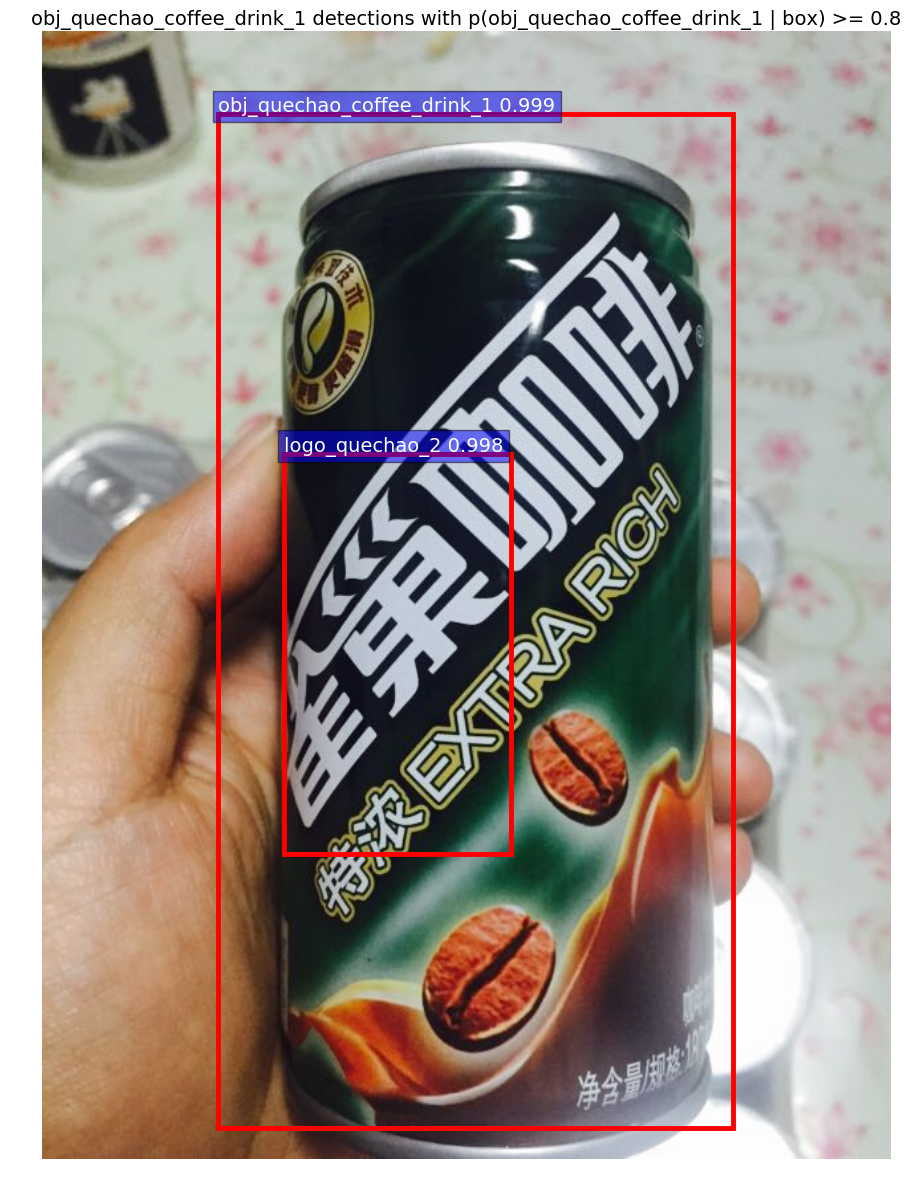

In [9]:
single_test(60)

Detection took 0.129s for 300 object proposals


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  app.launch_new_instance()


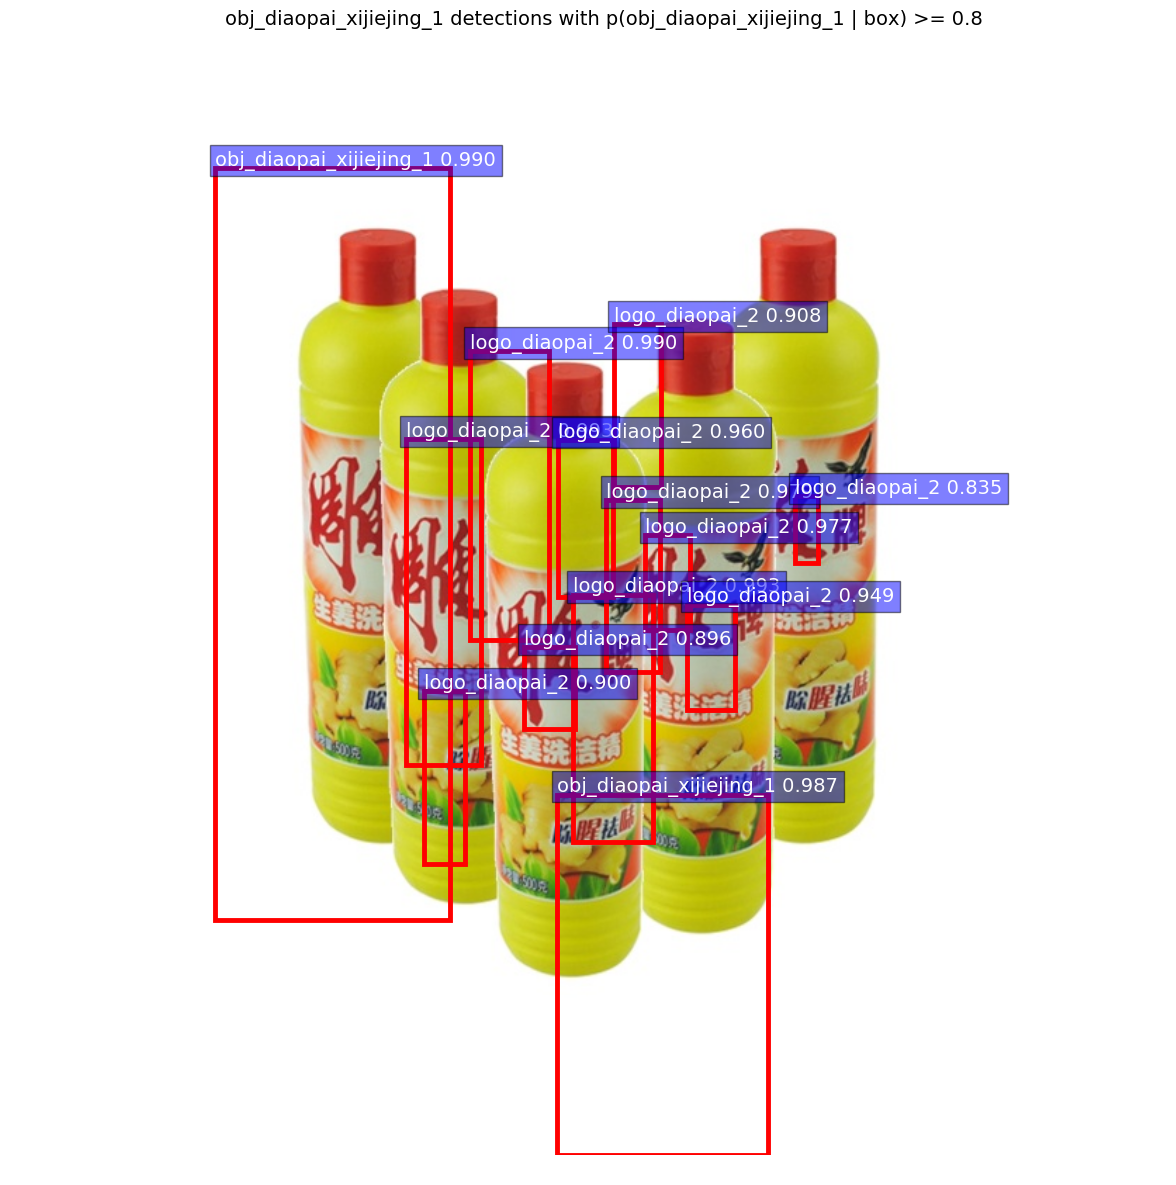

In [21]:
single_test(61)